<a href="https://colab.research.google.com/github/samyzaf/notebooks/blob/main/bsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solving the Black-Scholes-Merton Formula by FDM**

* **FDM** stands for **Finite Difference Method**.
* Thanks to
[Antoni Smolski](https://antonismolski.medium.com/?source=post_page-----965fd0539808--------------------------------)
for his inspiring BSM blog  
https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  
on which this notebook is based.

* The code in this notebook is largely Antoni's code with
  needed modifications to suite our course needs and targets.

* The Black-Scholes-Merton is the partial differential equation  
  $\quad
  v_t +rsv_s + \frac{1}{2}\sigma^2 s^2 v_{ss} = r v
  $

* $v(s,t)$ is the option value of a given asset at
   price $s$,  at time $t$.

* $r$ = risk-free interest rate

* $\sigma$ = the volatility of the stock (standard deviation)

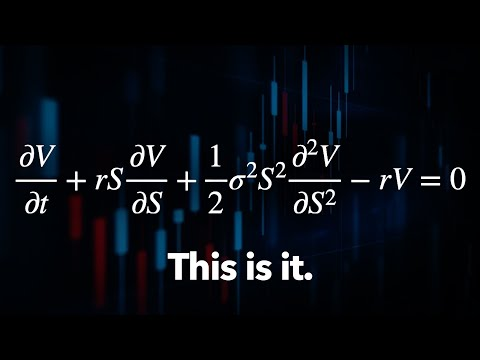

In [16]:
#@title Black-Scholes-Merton Formula
#@markdown  Motivation Video
YouTubeVideo("A5w-dEgIU1M", width=640, height=360)

* We use Python's [Numpy package](https://numpy.org), to model
  the **FDM** grid structure which represents the discrete
  version of $v(s,t)$.

* We use our **fdmtools** Python package,
  which is installed and imported by the next code cell.

In [1]:
%pip install -q https://samyzaf.com/fdmtools-3.zip
from fdmtools.bsm import *

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


* The implementation is the straightforward modification of
  Antoni Smolski code.

* I highly recommend reading his Blog!  
  https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  

In [2]:
def Solve(sigma, r, K, T, Ns, Nt=0):
    Price = np.zeros(Ns + 1)            # Ns = Number of Asset steps array
    S = 3*K                             # Max asset price
    ds = S/Ns                           # asset price step
    if Nt==0:                           # Automatic optimal selection of time step
        dt = 0.9 / (sigma**2 * Ns**2)   # Stable optimal value of dt
        Nt = int(T/dt) + 1              # Number of time steps
    dt = T / Nt                         # Ensure that T is an integer number of time steps away
    V = np.zeros((Ns+1, Nt+1))          # Option Value Array (V FDM grid)

    for i in range(Ns+1):
        Price[i] = i*ds
        V[i,0] = max(Price[i] - K, 0)   # Initial condition at time t=0

    for k in range(1, Nt+1):  # Time loop
        # And now ta dam ... Nobel prize winning diff equation ;)
        for i in range(1, Ns):  # Asset loop
            delta = (V[i+1,k-1] - V[i-1,k-1]) / (2*ds)                 # Vs[i,k] as central difference
            gamma = (V[i+1,k-1] - 2*V[i,k-1] + V[i-1,k-1]) / (ds**2)   # Vss[i,k] as central difference
            theta = -0.5 * sigma**2 * Price[i]**2 * gamma - r*Price[i]*delta + r*V[i,k-1]
            V[i, k] = V[i, k - 1] - dt * theta

        V[0,k] = 0                     # Boundary condition at s=0
        V[Ns,k] = S - K*exp(-r*k*dt)   # Boundary condition at s=S (Smax)

    asset_steps = np.arange(0, Ns + 1) * ds  # Asset price steps from 0 to S (i*ds, i=0,1,..,Ns)
    time_steps = np.arange(0, Nt + 1) * dt   # Time steps from 0 to T (k*dt, k=0,1,..,Nt)
    rounded_asset_steps = np.round(asset_steps, decimals=3)
    rounded_time_steps = np.round(time_steps, decimals=3)
    #data = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)
    data = pd.DataFrame(np.transpose(V), index=rounded_time_steps, columns=rounded_asset_steps).round(3)

    return data  # Output array as pandas data frame object



In [6]:
def bsm_heatmap(data):
    plt.clf()
    plt.locator_params(axis='x', nbins=40)
    plt.locator_params(axis='y', nbins=T*10)
    ds = S/Ns
    dt = 0.9/(sigma**2 * Ns**2)
    params = [
        f"sigma = {sigma}",
        f"K = {K}",
        f"ds = {ds:.3f}",
        f"dt = {dt:.3f}",
        f"r = {r:.4f}",
    ]
    text = ' ; '.join(params)
    ax = plt.gca()
    ax.tick_params(labelrotation=45, labelsize=8)
    ax.text(0.0, 1.03, text, fontsize=12, fontweight="bold", linespacing=1.0, transform=ax.transAxes)
    ax.text(K/S, 0.95, f"K={K}", fontsize=12, fontweight="bold", color="white", transform=ax.transAxes)
    plt.xlabel("Asset Steps", fontsize=12, fontweight="normal")
    plt.ylabel("Time Steps", fontsize=12, fontweight="normal")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: f"{x*ds:0.3f}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: f"{y*dt:0.3f}"))
    #colormap = "YlGnBu"
    colormap = "jet"
    plt.pcolormesh(data, cmap=colormap) #, vmin=Umin, vmax=Umax)
    ax.axvline(x=int(K/ds), color='white', linewidth=0.6)
    plt.colorbar()
    plt.tight_layout()
    return plt

In [7]:
K = 50            # Option strike price
S = 3*K           # Maximum asset price
T = 3             # Maximum time (in year units)
Ns = 40           # number of asset price steps
Nt = 0            # Let Solve choose an optimal number of time steps
sigma = 0.4       # Asset price sensitivity (aka volatility)
r = 0.05          # Interest rate

data = Solve(sigma, r, K, T, Ns, Nt)

,0.00,3.75,7.50,11.25,15.00,18.75,22.50,26.25,30.00,33.75,...,116.25,120.00,123.75,127.50,131.25,135.00,138.75,142.50,146.25,150.00
2.968,0.0,0.001,0.024,0.144,0.458,1.038,1.914,3.093,4.561,6.296,...,74.438,78.017,81.606,85.203,88.807,92.417,96.031,99.650,103.272,106.897
2.972,0.0,0.001,0.024,0.145,0.460,1.040,1.918,3.098,4.567,6.303,...,74.448,78.026,81.615,85.212,88.816,92.425,96.040,99.658,103.280,106.904
2.975,0.0,0.001,0.025,0.145,0.461,1.043,1.922,3.103,4.574,6.311,...,74.457,78.036,81.624,85.221,88.824,92.434,96.048,99.666,103.288,106.912
2.979,0.0,0.001,0.025,0.146,0.463,1.045,1.926,3.108,4.580,6.318,...,74.466,78.045,81.633,85.229,88.833,92.442,96.056,99.674,103.295,106.919
2.982,0.0,0.001,0.025,0.146,0.464,1.048,1.930,3.113,4.586,6.325,...,74.476,78.054,81.642,85.238,88.841,92.450,96.064,99.682,103.303,106.927
2.986,0.0,0.001,0.025,0.147,0.465,1.050,1.933,3.119,4.592,6.333,...,74.485,78.063,81.651,85.247,88.850,92.459,96.072,99.690,103.311,106.934
2.989,0.0,0.001,0.025,0.147,0.467,1.053,1.937,3.124,4.599,6.340,...,74.495,78.072,81.660,85.256,88.858,92.467,96.081,99.698,103.319,106.942
2.993,0.0,0.001,0.025,0.148,0.468,1.055,1.941,3.129,4.605,6.347,...,74.504,78.082,81.669,85.265,88.867,92.475,96.089,99.706,103.326,106.949
2.996,0.0,0.001,0.025,0.149,0.470,1.058,1.945,3.134,4.611,6.355,...,74.513,78.091,81.678,85.273,88.876,92.484,96.097,99.714,103.334,106.957
3.000,0.0,0.001,0.025,0.149,0.471,1.060,1.949,3.139,4.617,6.362,...,74.523,78.100,81.687,85.282,88.884,92.492,96.105,99.722,103.342,106.965


* **data** is a [Pandas](https://pandas.pydata.org/) data frame object which holds the FDM grid solution in a tabular form, which is easy to manipulate and getting information from.

* Here are the last 10 rows of this table. The columns are asset price steps, and the lines are time steps.

In [9]:
data.tail(10)

,0.00,3.75,7.50,11.25,15.00,18.75,22.50,26.25,30.00,33.75,...,116.25,120.00,123.75,127.50,131.25,135.00,138.75,142.50,146.25,150.00
2.968,0.0,0.001,0.024,0.144,0.458,1.038,1.914,3.093,4.561,6.296,...,74.438,78.017,81.606,85.203,88.807,92.417,96.031,99.650,103.272,106.897
2.972,0.0,0.001,0.024,0.145,0.460,1.040,1.918,3.098,4.567,6.303,...,74.448,78.026,81.615,85.212,88.816,92.425,96.040,99.658,103.280,106.904
2.975,0.0,0.001,0.025,0.145,0.461,1.043,1.922,3.103,4.574,6.311,...,74.457,78.036,81.624,85.221,88.824,92.434,96.048,99.666,103.288,106.912
2.979,0.0,0.001,0.025,0.146,0.463,1.045,1.926,3.108,4.580,6.318,...,74.466,78.045,81.633,85.229,88.833,92.442,96.056,99.674,103.295,106.919
2.982,0.0,0.001,0.025,0.146,0.464,1.048,1.930,3.113,4.586,6.325,...,74.476,78.054,81.642,85.238,88.841,92.450,96.064,99.682,103.303,106.927
2.986,0.0,0.001,0.025,0.147,0.465,1.050,1.933,3.119,4.592,6.333,...,74.485,78.063,81.651,85.247,88.850,92.459,96.072,99.690,103.311,106.934
2.989,0.0,0.001,0.025,0.147,0.467,1.053,1.937,3.124,4.599,6.340,...,74.495,78.072,81.660,85.256,88.858,92.467,96.081,99.698,103.319,106.942
2.993,0.0,0.001,0.025,0.148,0.468,1.055,1.941,3.129,4.605,6.347,...,74.504,78.082,81.669,85.265,88.867,92.475,96.089,99.706,103.326,106.949
2.996,0.0,0.001,0.025,0.149,0.470,1.058,1.945,3.134,4.611,6.355,...,74.513,78.091,81.678,85.273,88.876,92.484,96.097,99.714,103.334,106.957
3.000,0.0,0.001,0.025,0.149,0.471,1.060,1.949,3.139,4.617,6.362,...,74.523,78.100,81.687,85.282,88.884,92.492,96.105,99.722,103.342,106.965


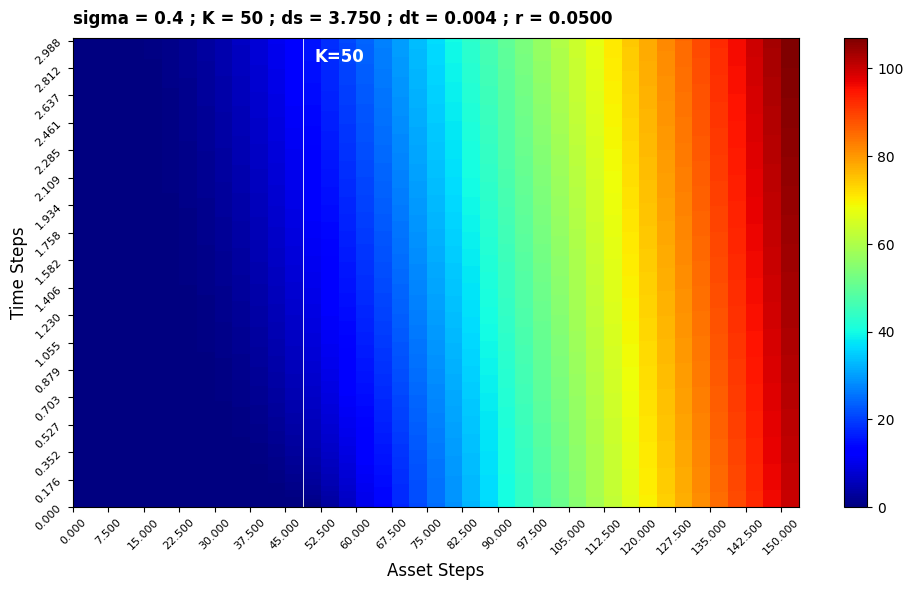

In [8]:
plt.figure(figsize=(10, 6))
bsm_heatmap(data)
plt.show()


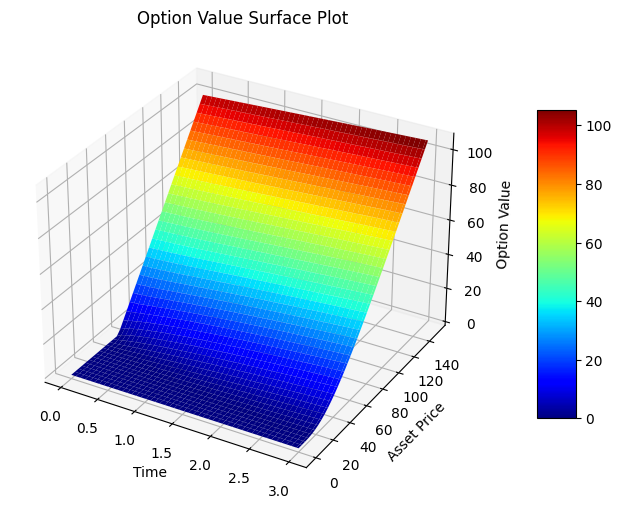

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

Y,X = np.meshgrid(data.columns, data.index)
Z = data.values
colormap = "jet"
surf = ax.plot_surface(X, Y, Z, cmap=colormap)

ax.set_xlabel('Time')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface Plot')
fig.colorbar(surf, shrink=0.5, aspect=8, pad=0.1)
plt.show()